In [181]:
import balltracking.balltrack as blt
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib import rc
# Load FLCT
from pathlib import Path, PurePath
from IPython.display import display
import time
import pandas as pd


matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})
pd.options.display.max_columns = None

In [2]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return np.array([vx, vy])


def smooth_vel(v, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(v[0,...], box, mode='same')
        vys2 = convolve2d(v[1,...], box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(v[0,...], sigma=sigma, order=0)
        vys2 = gaussian_filter(v[1,...], sigma=sigma, order=0)
        
    vm = np.sqrt(vxs2**2 + vys2**2)
    return np.array([vxs2, vys2, vm])


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

In [243]:
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
outputdir = os.path.join(datadir, 'comparisons')

u = 368000 / 60

fwhms = [7,11,15]
kernels = ['boxcar', 'gaussian']
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
fovs = [np.s_[fwhm:-fwhm:fwhm, fwhm:-fwhm:fwhm] for fwhm in fwhms]

nframes = range(30, 365, 5)
tranges = [[0, nt] for nt in range(30, 365, 5)]
nflows = len(tranges)
print("number of time-averaged flow maps: ", nflows)

number of time-averaged flow maps:  67


### Load Stein simulation data

In [244]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
v_stein_l = [load_vel_mean((svx_files, svy_files), trange) for trange in tranges]
# smooth the Stein velocities 
v_stein_sm = [[smooth_vel(v, fwhm, kernel=kernel) for v in v_stein_l] for fwhm in fwhms]
npts_ = [v_stein_sm[f][0][0][fov].size for f, fov in enumerate(fovs)]

In [245]:
df_list = []
for i, fwhm_i in enumerate(fwhms):
    fov = fovs[i]
    # Load Balltrack velocities (processed with balltracking_scripts/generic_balltrack.py)
    # bvxs = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vx'] for trange in tranges]
    bvs = [np.array([np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm_i, trange[1])))[var] for var in ['vx', 'vy']]) for trange in tranges]
    bvsm = [np.sqrt(bvs[j][0][:]**2 + bvs[j][1][:]**2) for j in range(nflows)]
    
    # Load and smooth FLCT velocities
    if fwhm_i == 7:
        fvs2 = [np.array([fv[0], fv[1], np.sqrt(fv[0][:]**2 + fv[1][:]**2)]) for fv in fvs]
    else:
        # Smooth Stein velocities
        fvs2 = [smooth_vel(fv, fwhm_i, kernel=kernel) for fv in fvs]
        
        
    df = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                               'vx_balltrack': bvs[j][0][fov].ravel()*u, 'vy_balltrack': bvs[j][1][fov].ravel()*u,
                               'vx_flct':fvs2[j][0][fov].ravel()*u, 'vy_flct':fvs2[j][1][fov].ravel()*u,    
                               'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 'vmag_balltracking': bvsm[j][fov].ravel()*u, 'vmag_flct':fvs2[j][2][fov].ravel()*u,
                               'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel}) for j in range(nflows)])
    
    df_list.append(df)

df0 = pd.concat(df_list)

In [247]:
df0.head()

,vx_stein,vy_stein,vx_balltrack,vy_balltrack,vx_flct,vy_flct,vmag_stein,vmag_balltracking,vmag_flct,nframes,FWHM,kernel
0,354.526110,-179.987467,195.397963,64.579605,134.295273,-118.405258,397.598102,205.793317,179.039169,30,7,boxcar
1,176.649555,-54.770955,438.153053,-97.000093,225.890701,55.055073,184.945729,448.761759,232.503067,30,7,boxcar
2,126.318336,157.891595,49.610557,258.587479,62.797581,158.130753,202.203060,263.303421,170.143692,30,7,boxcar
3,-5.722524,143.082169,88.028339,53.586611,-139.648758,160.592041,143.196558,103.055875,212.818192,30,7,boxcar
4,-558.727541,-20.839990,-438.695106,-107.343046,-408.404938,41.246597,559.116061,451.636940,410.482513,30,7,boxcar


### Balltracking data

In [260]:
# Calibration file path
cal_file = os.path.expanduser('~/Data/sanity_check/stein_series/correlation_dataframe.csv')
caldf = pd.read_csv(cal_file)
display(caldf.head())

,rs,intsteps,ballspacing,dp,sigma_factor,f_radius,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,a_top_0,a_bot_0,corr_uncal,corr,corr_top,corr_bot
0,2,3,1,0.2,1.0,0,0.256293,-0.002778,0.225452,-0.002344,-0.101383,-0.082990,-0.062579,-0.043170,-0.024134,-0.004836,0.013763,0.032909,0.053006,0.071389,0.091687,3.901782,4.435543,0.749145,0.747198,0.700015,0.646444
1,2,3,1,0.2,1.0,1,0.219862,-0.003056,0.182821,-0.001626,-0.085678,-0.069240,-0.052896,-0.036635,-0.020284,-0.004532,0.011582,0.027263,0.043591,0.059275,0.076047,4.548311,5.469827,0.875152,0.874690,0.830433,0.815424
2,2,3,1,0.2,1.0,2,0.221249,-0.003047,0.186535,-0.001840,-0.086727,-0.070381,-0.054046,-0.036783,-0.021073,-0.004714,0.011879,0.027485,0.043779,0.060008,0.076819,4.519798,5.360934,0.872427,0.871615,0.829833,0.806353
3,2,3,1,0.2,1.0,3,0.226822,-0.003078,0.193181,-0.001796,-0.089721,-0.072074,-0.054714,-0.037900,-0.021678,-0.004751,0.012033,0.028546,0.045479,0.061896,0.079268,4.408748,5.176497,0.868528,0.867517,0.827131,0.797443
4,2,3,1,0.2,1.0,4,0.233845,-0.002892,0.202096,-0.002073,-0.092568,-0.074779,-0.056840,-0.039741,-0.022211,-0.005117,0.012670,0.029924,0.047195,0.064411,0.082444,4.276342,4.948153,0.857986,0.857252,0.810646,0.788075


In [287]:
caldf.iloc[[np.argmax(caldf['corr'].values), np.argmax(caldf['corr_top'].values), np.argmax(caldf['corr_bot'].values)]]

,rs,intsteps,ballspacing,dp,sigma_factor,f_radius,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,a_top_0,a_bot_0,corr_uncal,corr,corr_top,corr_bot
2913,2,5,2,0.25,1.5,1,0.555156,-0.007590,0.583744,-0.007763,-0.242273,-0.197743,-0.152287,-0.107855,-0.060122,-0.014993,0.029562,0.075856,0.121505,0.166979,0.212485,1.801296,1.713080,0.902267,0.902203,0.868297,0.874885
2546,2,5,1,0.25,2.0,2,0.297765,-0.004737,0.259234,-0.002366,-0.118016,-0.095657,-0.074415,-0.051846,-0.030496,-0.007127,0.014821,0.038038,0.060643,0.081804,0.104123,3.358354,3.857517,0.894176,0.893239,0.868541,0.839359
1745,2,4,2,0.25,2.0,1,0.474136,-0.006694,0.508751,-0.006642,-0.209384,-0.170645,-0.130936,-0.092858,-0.052713,-0.013650,0.025723,0.065462,0.104940,0.144338,0.183029,2.109098,1.965598,0.897845,0.897469,0.855705,0.879468


In [295]:
cal_file2 = os.path.expanduser('~/Data/sanity_check/stein_series/correlation_dataframe2.csv')
caldf2 = pd.read_csv(cal_file2)
caldf2.iloc[[np.argmax(caldf2['corr'].values), np.argmax(caldf2['corr_top'].values), np.argmax(caldf2['corr_bot'].values)]]

,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,kernel,fwhm,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20,a_top_0,a_bot_0,corr_uncal,corr,corr_top,corr_bot
3021,2,5,2,0.25,1.5,1,boxcar,7,1.801228,0.013672,1.713018,0.013298,-0.118021,-0.096502,-0.073894,-0.052891,-0.029532,-0.008202,0.014364,0.036748,0.059552,0.081383,0.103506,-0.124252,-0.101241,-0.078393,-0.054964,-0.030590,-0.006790,0.015198,0.039108,0.061953,0.085596,0.108980,0.555177,0.583765,0.902267,0.902291,0.868297,0.874885
2492,2,5,1,0.25,2.0,2,boxcar,7,3.358044,0.015907,3.857307,0.009125,-0.063982,-0.051947,-0.040799,-0.028790,-0.017308,-0.004757,0.006957,0.019672,0.031340,0.042691,0.054820,-0.054033,-0.043710,-0.033616,-0.023056,-0.013188,-0.002370,0.007864,0.018366,0.029303,0.039113,0.049304,0.297792,0.259248,0.894176,0.894704,0.868541,0.839359
1842,2,4,2,0.23,2.0,2,boxcar,7,2.068565,0.013749,1.957719,0.012887,-0.102556,-0.083232,-0.065260,-0.045709,-0.026591,-0.007763,0.013064,0.031782,0.051848,0.071312,0.089990,-0.108636,-0.089105,-0.067631,-0.047482,-0.026517,-0.006402,0.013666,0.034622,0.054841,0.075135,0.095100,0.483427,0.510799,0.901524,0.901715,0.860641,0.879542


In [294]:
caldf = pd.read_csv(os.path.expanduser('~/Data/sanity_check/stein_series/correlation_dataframe3.csv'))
caldf.iloc[[np.argmax(caldf['corr'].values), np.argmax(caldf['corr_top'].values), np.argmax(caldf['corr_bot'].values)]]

,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,kernel,fwhm,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20,corr_uncal,corr,corr_top,corr_bot
3021,2,5,2,0.25,1.5,1,boxcar,7,1.801228,0.013672,1.713018,0.013298,-0.118021,-0.096502,-0.073894,-0.052891,-0.029532,-0.008202,0.014364,0.036748,0.059552,0.081383,0.103506,-0.124252,-0.101241,-0.078393,-0.054964,-0.030590,-0.006790,0.015198,0.039108,0.061953,0.085596,0.108980,0.902267,0.902203,0.868297,0.874885
2492,2,5,1,0.25,2.0,2,boxcar,7,3.358044,0.015907,3.857307,0.009125,-0.063982,-0.051947,-0.040799,-0.028790,-0.017308,-0.004757,0.006957,0.019672,0.031340,0.042691,0.054820,-0.054033,-0.043710,-0.033616,-0.023056,-0.013188,-0.002370,0.007864,0.018366,0.029303,0.039113,0.049304,0.894176,0.893239,0.868541,0.839359
1842,2,4,2,0.23,2.0,2,boxcar,7,2.068565,0.013749,1.957719,0.012887,-0.102556,-0.083232,-0.065260,-0.045709,-0.026591,-0.007763,0.013064,0.031782,0.051848,0.071312,0.089990,-0.108636,-0.089105,-0.067631,-0.047482,-0.026517,-0.006402,0.013666,0.034622,0.054841,0.075135,0.095100,0.901524,0.901283,0.860641,0.879542


In [296]:
caldf = pd.read_csv(os.path.expanduser('~/Data/sanity_check/stein_series/correlation_dataframe4.csv'))
caldf.iloc[[np.argmax(caldf['corr'].values), np.argmax(caldf['corr_top'].values), np.argmax(caldf['corr_bot'].values)]]

,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,kernel,fwhm,corr_uncal,corr,corr_top,corr_bot,MAE_uncal_vx,MAE_uncal_vy,MAE_cal_vx,MAE_cal_vy,RMSE_uncal_vx,RMSE_uncal_vy,RMSE_cal_vx,RMSE_cal_vy,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20
3021,2,5,2,0.25,1.5,1,boxcar,7,0.902267,0.902203,0.868297,0.874885,282.245967,290.773011,282.245967,213.307931,356.015522,366.040176,356.015522,271.023439,1.801228,0.013672,1.713018,0.013298,-0.118021,-0.096502,-0.073894,-0.052891,-0.029532,-0.008202,0.014364,0.036748,0.059552,0.081383,0.103506,-0.124252,-0.101241,-0.078393,-0.054964,-0.030590,-0.006790,0.015198,0.039108,0.061953,0.085596,0.108980
2492,2,5,1,0.25,2.0,2,boxcar,7,0.894176,0.893239,0.868541,0.839359,383.617761,391.977605,383.617761,222.529774,479.696996,487.561745,479.696996,278.435069,3.358044,0.015907,3.857307,0.009125,-0.063982,-0.051947,-0.040799,-0.028790,-0.017308,-0.004757,0.006957,0.019672,0.031340,0.042691,0.054820,-0.054033,-0.043710,-0.033616,-0.023056,-0.013188,-0.002370,0.007864,0.018366,0.029303,0.039113,0.049304
1842,2,4,2,0.23,2.0,2,boxcar,7,0.901524,0.901283,0.860641,0.879542,304.482870,312.899606,304.482870,215.332981,381.294669,393.119915,381.294669,272.449426,2.068565,0.013749,1.957719,0.012887,-0.102556,-0.083232,-0.065260,-0.045709,-0.026591,-0.007763,0.013064,0.031782,0.051848,0.071312,0.089990,-0.108636,-0.089105,-0.067631,-0.047482,-0.026517,-0.006402,0.013666,0.034622,0.054841,0.075135,0.095100


In [274]:
print(caldf.corr_top.max(), caldf.corr_bot.max())
print(caldf.corr_top.values.argmax())
caldf.iloc[[caldf.corr_top.values.argmax(),caldf.corr_bot.values.argmax(), caldf.corr_uncal.values.argmax()]]

0.8685413081415612 0.8794679776184197
2546


,rs,intsteps,ballspacing,dp,sigma_factor,f_radius,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,a_top_0,a_bot_0,corr_uncal,corr,corr_top,corr_bot
2546,2,5,1,0.25,2.0,2,0.297765,-0.004737,0.259234,-0.002366,-0.118016,-0.095657,-0.074415,-0.051846,-0.030496,-0.007127,0.014821,0.038038,0.060643,0.081804,0.104123,3.358354,3.857517,0.894176,0.893239,0.868541,0.839359
1745,2,4,2,0.25,2.0,1,0.474136,-0.006694,0.508751,-0.006642,-0.209384,-0.170645,-0.130936,-0.092858,-0.052713,-0.013650,0.025723,0.065462,0.104940,0.144338,0.183029,2.109098,1.965598,0.897845,0.897469,0.855705,0.879468
2913,2,5,2,0.25,1.5,1,0.555156,-0.007590,0.583744,-0.007763,-0.242273,-0.197743,-0.152287,-0.107855,-0.060122,-0.014993,0.029562,0.075856,0.121505,0.166979,0.212485,1.801296,1.713080,0.902267,0.902203,0.868297,0.874885


In [182]:
cal_file2 = os.path.expanduser('~/Data/sanity_check/stein_series/calibration/calibration_fwhm_kernel.csv')
caldf2 = pd.read_csv(cal_file2)
display(caldf2.head())

,Unnamed: 0,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,nframes,index,kernel,fwhm,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20
0,0,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm7,boxcar,7,1.789291,0.011463,1.702438,0.010836,-0.118314,-0.095680,-0.073219,-0.051198,-0.029264,-0.006212,0.015862,0.038421,0.061103,0.082727,0.105303,-0.123882,-0.100499,-0.077337,-0.053638,-0.029407,-0.005391,0.017180,0.040642,0.064215,0.087256,0.110845
1,1,2,5,2,0.25,1.5,1.0,60,gaussian_fwhm7,gaussian,7,1.790703,0.011472,1.704054,0.010790,-0.118220,-0.095605,-0.073158,-0.051159,-0.029240,-0.006220,0.015828,0.038359,0.061022,0.082661,0.105260,-0.123726,-0.100378,-0.077232,-0.053529,-0.029345,-0.005375,0.017159,0.040582,0.064148,0.087236,0.110811
2,2,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm9,boxcar,9,1.789958,0.011277,1.702825,0.010575,-0.118202,-0.095543,-0.073091,-0.051095,-0.029162,-0.006052,0.016037,0.038522,0.061199,0.082777,0.105306,-0.123789,-0.100365,-0.077207,-0.053416,-0.029178,-0.005149,0.017399,0.040844,0.064297,0.087407,0.110843
3,3,2,5,2,0.25,1.5,1.0,60,gaussian_fwhm9,gaussian,9,1.790936,0.011325,1.704346,0.010591,-0.118143,-0.095508,-0.073070,-0.051085,-0.029165,-0.006108,0.015963,0.038437,0.061107,0.082723,0.105288,-0.123669,-0.100268,-0.077128,-0.053365,-0.029166,-0.005181,0.017323,0.040735,0.064200,0.087354,0.110810
4,4,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm11,boxcar,11,1.790514,0.011176,1.703702,0.010419,-0.118111,-0.095454,-0.072998,-0.051023,-0.029103,-0.005998,0.016111,0.038522,0.061237,0.082820,0.105340,-0.123691,-0.100222,-0.077082,-0.053277,-0.029031,-0.004995,0.017511,0.040901,0.064285,0.087488,0.110844


In [251]:

dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    fov = fovs[i]
    # Load Balltrack velocities. processed with balltracking_scripts/generic_balltrack.py, calibrated with balltracking/generic_calibration
    # bvxs = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vx'] for trange in tranges]
    bvs = [np.array([np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm_i, trange[1])))[var] for var in ['vx', 'vy']]) for trange in tranges]
    bvsm = [np.sqrt(bvs[j][0][:]**2 + bvs[j][1][:]**2) for j in range(nflows)]
    
    # Fit Balltracking to Stein simulation
    bps, brs, _, _, _ = zip(*[np.polyfit(bvs[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    brs = [np.sqrt(br[0]/npts_[i]) for br in brs]
    print('Balltrack residuals from fit: ', brs[0])
    b_alphas, b_offsets = map(list, zip(*bps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - bvs[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSEs = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE Balltracking = ',  b_RMSEs[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                                   'vx': bvs[j][0][fov].ravel()*u, 'vy': bvs[j][1][fov].ravel()*u, 'vmag':bvsm[j][fov].ravel()*u,
                                   'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field_masked[j], 
                                   'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'}) for j in range(nflows)])
    
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    bMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    # Correlations between Balltracking and simulation
    bcorrs = [calc_c_pearson(v_stein_sm[i][j][0], bvs[j][0], v_stein_sm[i][j][1], bvs[j][1], fov=fov) for j in range(len(tranges))]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':b_alphas, 'RMSE':RMSEs, 'MAPE':bMAPE, 'correlation':bcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'})
    
    dfs1.append(df1)
    dfs2.append(df2)

bdf1 = pd.concat(dfs1)
bdf2 = pd.concat(dfs2)
display(bdf1.head())
display(bdf2.head())

Balltrack residuals from fit:  273.6317507203576
Balltrack residuals from fit:  170.90434718854684
Balltrack residuals from fit:  120.39669989614572


,vx_stein,vy_stein,vx,vy,vmag,vmag_stein,error,APE,nframes,FWHM,kernel,Algorithm
0,354.526110,-179.987467,195.397963,64.579605,205.793317,397.598102,159.128147,48.240870,30,7,boxcar,Balltracking
1,176.649555,-54.770955,438.153053,-97.000093,448.761759,184.945729,261.503499,142.645105,30,7,boxcar,Balltracking
2,126.318336,157.891595,49.610557,258.587479,263.303421,202.203060,76.707779,30.217327,30,7,boxcar,Balltracking
3,-5.722524,143.082169,88.028339,53.586611,103.055875,143.196558,93.750863,28.031877,30,7,boxcar,Balltracking
4,-558.727541,-20.839990,-438.695106,-107.343046,451.636940,559.116061,120.032434,19.223043,30,7,boxcar,Balltracking


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,0.995342,274.298689,26.534130,0.893944,7,boxcar,Balltracking
1,35,1.005569,259.253389,25.896488,0.904080,7,boxcar,Balltracking
2,40,1.016424,244.474956,24.126279,0.913900,7,boxcar,Balltracking
3,45,1.027550,232.062343,22.677948,0.921573,7,boxcar,Balltracking
4,50,1.032829,219.134725,22.199644,0.927716,7,boxcar,Balltracking


### FLCT data

In [252]:
# Load fits files
datadir_flct = os.path.expanduser('~/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma4')
fvx_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vx*.fits'))))
fvy_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vy*.fits'))))

In [253]:
# Average over time
fvs = [load_vel_mean((fvx_files, fvy_files), trange) for trange in tranges]

In [254]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    if fwhm_i == 7:
        fvs2 = [np.array([fv[0], fv[1], np.sqrt(fv[0][:]**2 + fv[1][:]**2)]) for fv in fvs]
    else:
        # Smooth Stein velocities
        fvs2 = [smooth_vel(fv, fwhm_i, kernel=kernel) for fv in fvs]
    
    fov = fovs[i]
    # Fit FLCT to Stein simulation
    fps, frs, _, _, _ = zip(*[np.polyfit(fvs2[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    frs = [np.sqrt(fr[0]/npts_[i]) for fr in frs]
    print('FLCT residuals from fit: ', frs[0])
    f_alphas, f_offsets = map(list, zip(*fps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - fvs2[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSE_uncal = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE FLCT (uncalibrated) = ',  fRMSE_uncals[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                                   'vx':fvs2[j][0][fov].ravel()*u, 'vy':fvs2[j][1][fov].ravel()*u, 'vmag':fvs2[j][2][fov].ravel()*u,
                                   'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field_masked[j], 
                                   'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'}) for j in range(nflows)])  
    
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    fMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    # Correlations between FLCT and simulation
    fcorrs = [calc_c_pearson(v_stein_sm[i][j][0], fvs2[j][0], v_stein_sm[i][j][1], fvs2[j][1], fov=fov) for j in range(nflows)]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':f_alphas, 'RMSE':RMSE_uncal, 'MAPE':fMAPE, 'correlation':fcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'})
    dfs1.append(df1)
    dfs2.append(df2)
    
fdf1 = pd.concat(dfs1)
fdf2 = pd.concat(dfs2)
display(fdf1.head())
display(fdf2.head())

FLCT residuals from fit:  286.7493305655879
FLCT residuals from fit:  175.30516907970778
FLCT residuals from fit:  126.30100978193812


,vx_stein,vy_stein,vx,vy,vmag,vmag_stein,error,APE,nframes,FWHM,kernel,Algorithm
0,354.526110,-179.987467,134.295273,-118.405258,179.039169,397.598102,220.230837,54.969813,30,7,boxcar,FLCT
1,176.649555,-54.770955,225.890701,55.055073,232.503067,184.945729,49.241147,25.714213,30,7,boxcar,FLCT
2,126.318336,157.891595,62.797581,158.130753,170.143692,202.203060,63.520755,15.855036,30,7,boxcar,FLCT
3,-5.722524,143.082169,-139.648758,160.592041,212.818192,143.196558,133.926234,48.619627,30,7,boxcar,FLCT
4,-558.727541,-20.839990,-408.404938,41.246597,410.482513,559.116061,150.322603,26.583666,30,7,boxcar,FLCT


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,1.190955,302.186243,32.777062,0.879764,7,boxcar,FLCT
1,35,1.223405,285.602223,32.248110,0.896296,7,boxcar,FLCT
2,40,1.256524,273.111613,32.945171,0.908506,7,boxcar,FLCT
3,45,1.274272,263.031881,31.821561,0.916256,7,boxcar,FLCT
4,50,1.284025,253.809482,32.087524,0.922681,7,boxcar,FLCT


In [255]:
df1 = pd.concat([bdf1, fdf1]).reset_index()
df2 = pd.concat([bdf2, fdf2]).reset_index()

In [10]:
df2.query("Algorithm == 'FLCT' & FWHM == '15'").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
335,0,30,1.288291,157.243505,30.485652,0.951687,15,boxcar,FLCT
336,1,35,1.306828,151.368134,29.077890,0.958069,15,boxcar,FLCT
337,2,40,1.331990,149.235730,30.380086,0.962598,15,boxcar,FLCT
338,3,45,1.348828,148.509171,31.075292,0.964175,15,boxcar,FLCT
339,4,50,1.348549,148.639684,30.175492,0.965511,15,boxcar,FLCT


In [11]:
df2.query("Algorithm == 'Balltracking' & FWHM == '15'").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
134,0,30,0.973879,122.012264,15.849635,0.952576,15,boxcar,Balltracking
135,1,35,0.971125,117.438799,16.018201,0.957189,15,boxcar,Balltracking
136,2,40,0.989413,108.840533,14.352725,0.962171,15,boxcar,Balltracking
137,3,45,1.005849,104.198325,13.915472,0.965203,15,boxcar,Balltracking
138,4,50,1.007878,100.176293,11.941320,0.969160,15,boxcar,Balltracking


In [256]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid')
%matplotlib inline

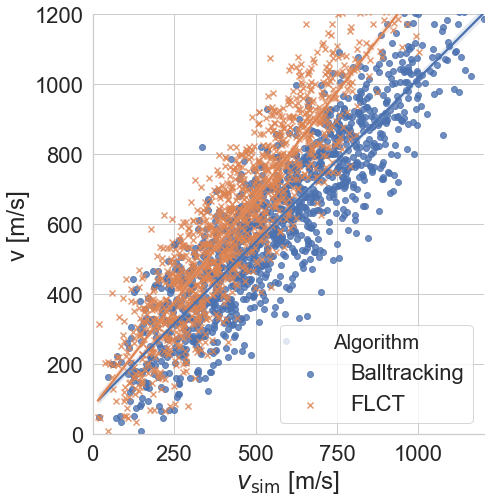

In [257]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vmag', y='vmag_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]');

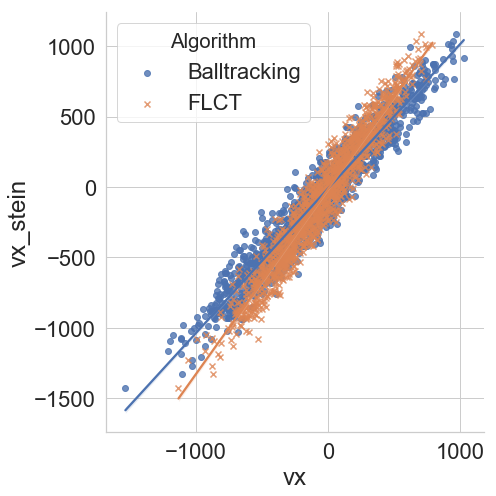

In [258]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vx', y='vx_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
#g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]')

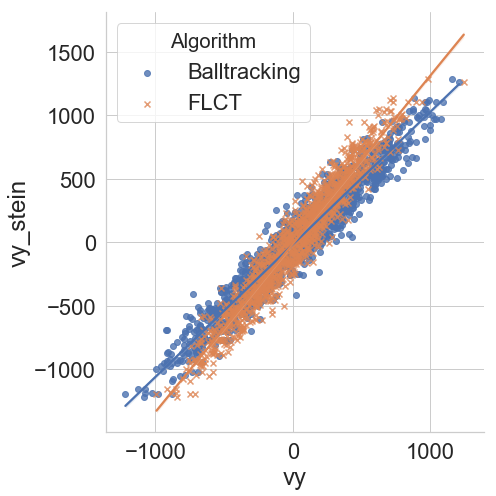

In [259]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vy', y='vy_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
#g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]')

In [185]:
df1.query("nframes == 190 & FWHM==7").vx_stein.values

array([  702.41340232,   349.87733943,  -146.23922338, ...,
        -938.15587635, -1025.09958571,  -608.72820971])

In [190]:
p, r, _, _, _ = np.polyfit(df1.query("Algorithm == 'Balltracking' & nframes == 30 & FWHM==11").vx_stein.values, df1.query("Algorithm == 'Balltracking' & nframes == 30 & FWHM==11").vx.values, 1, full=True)
p

array([0.89558851, 8.97705989])

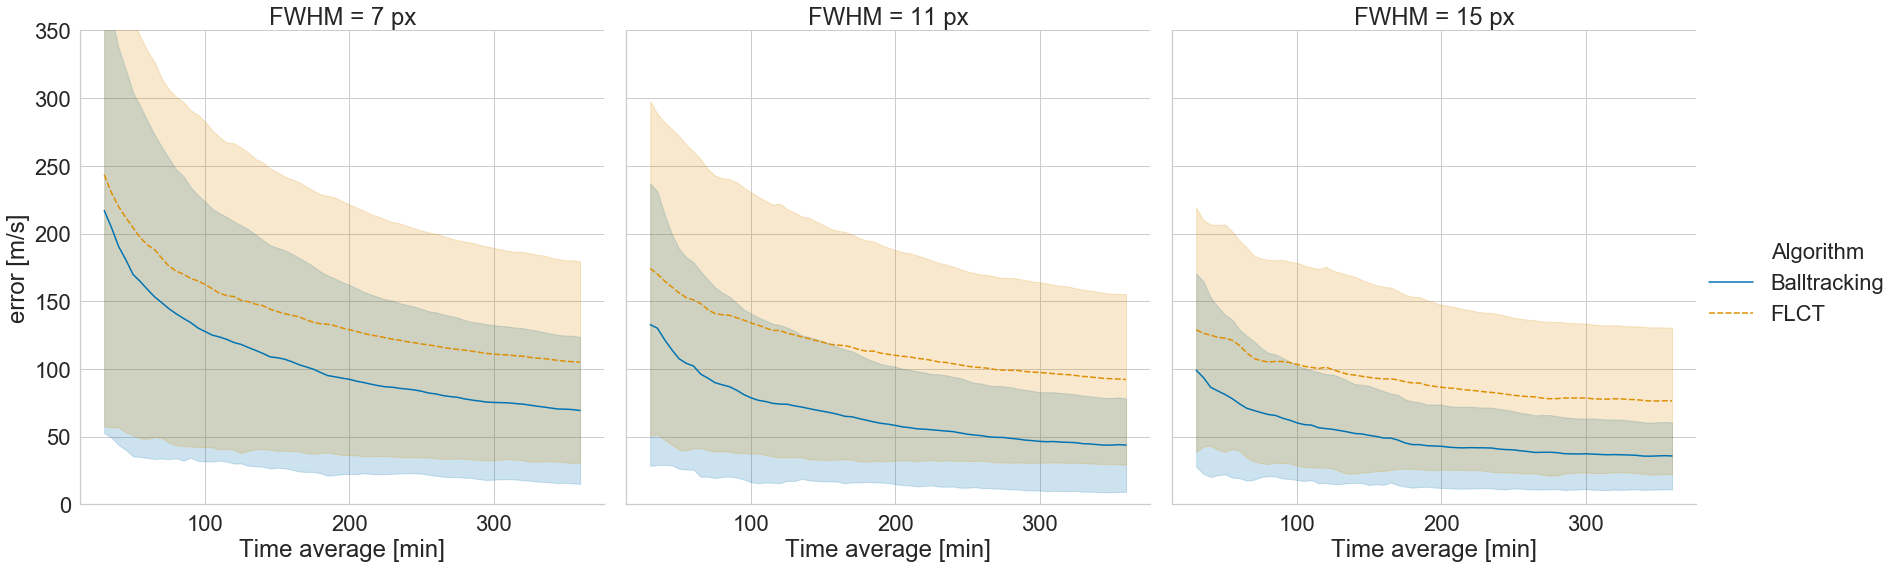

In [13]:
g1 = sns.relplot(data=df1, x='nframes', y='error',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]', ylabel='error [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'error.png'))

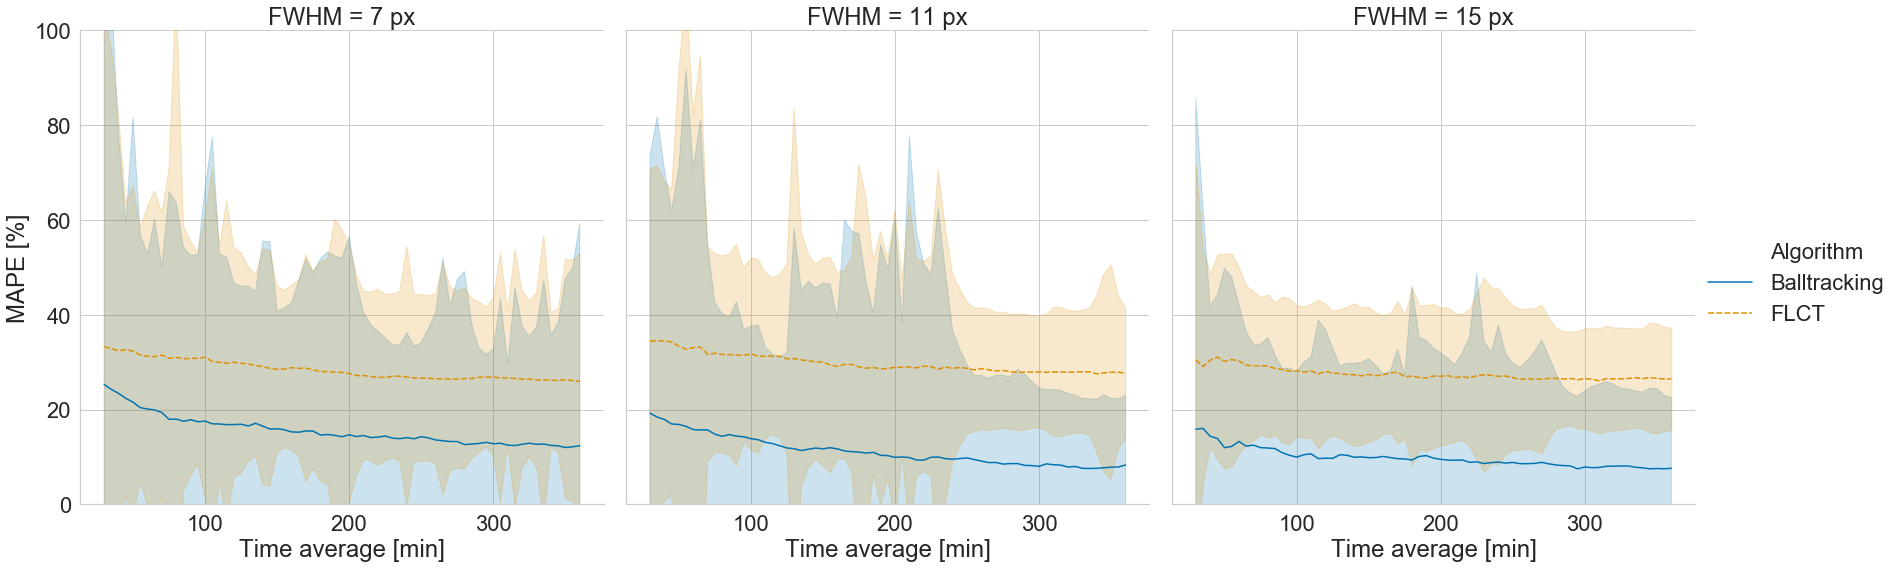

In [14]:
g1 = sns.relplot(data=df1, x='nframes', y='APE',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8, estimator=np.median)
g1.set(xlabel='Time average [min]', ylabel='MAPE [%]', ylim=[0, 100])
plt.savefig(PurePath(outputdir, 'MAPE.png'))

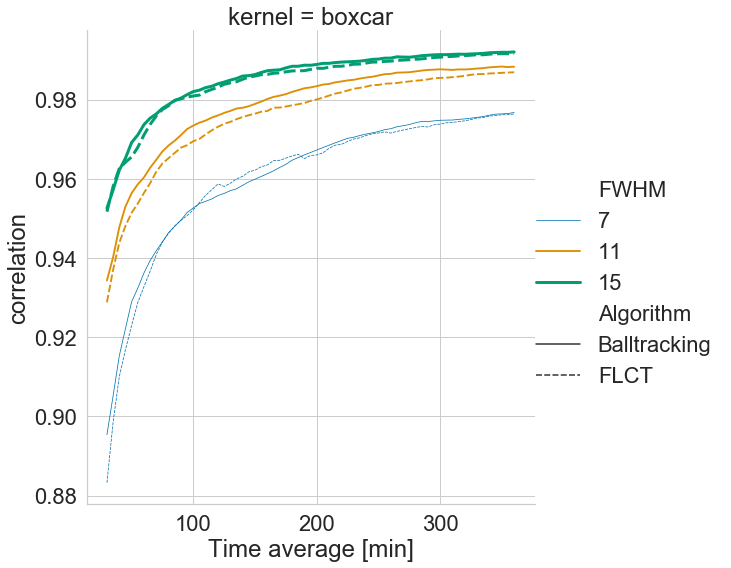

In [15]:
g1 = sns.relplot(data=df2, x='nframes', y='correlation', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]')
plt.savefig(PurePath(outputdir, 'correlation.png'))

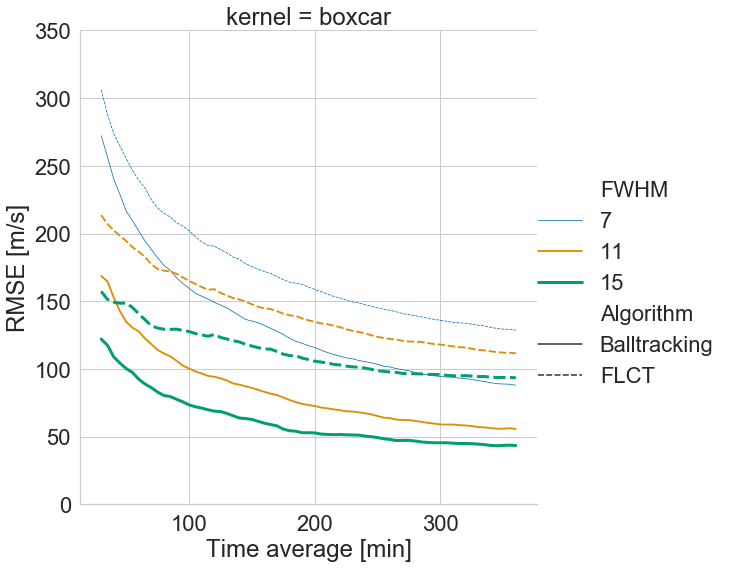

In [16]:
g2 = sns.relplot(data=df2, x='nframes', y='RMSE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g2.set(xlabel='Time average [min]', ylabel='RMSE [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'rmse.png'))


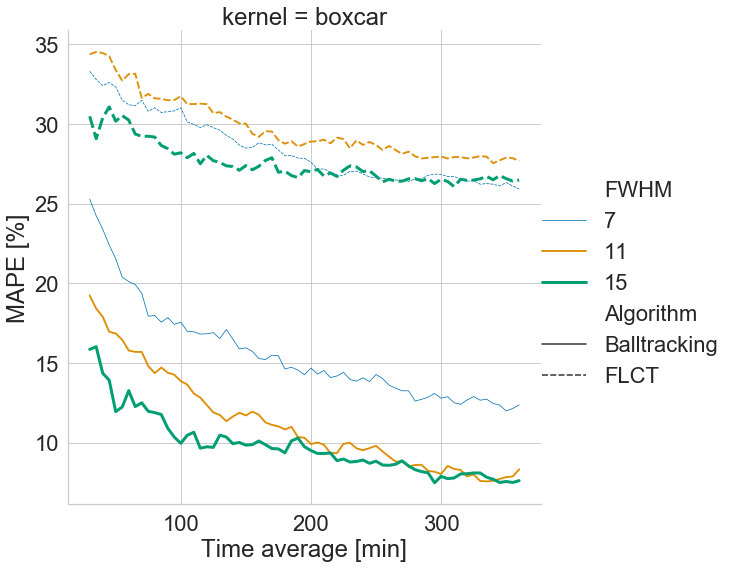

In [17]:
g3 = sns.relplot(data=df2, x='nframes', y='MAPE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g3.set(xlabel='Time average [min]', ylabel='MAPE [%]')
plt.savefig(PurePath(outputdir, 'mape.png'))

In [86]:
def hexbin(x, y, color, **kwargs):
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, mincnt=2, gridsize=(10, 30), cmap='inferno', **kwargs)
    # The number of total counts (i.e. # of independent samples) changes with the FWHM
    plt.colorbar();

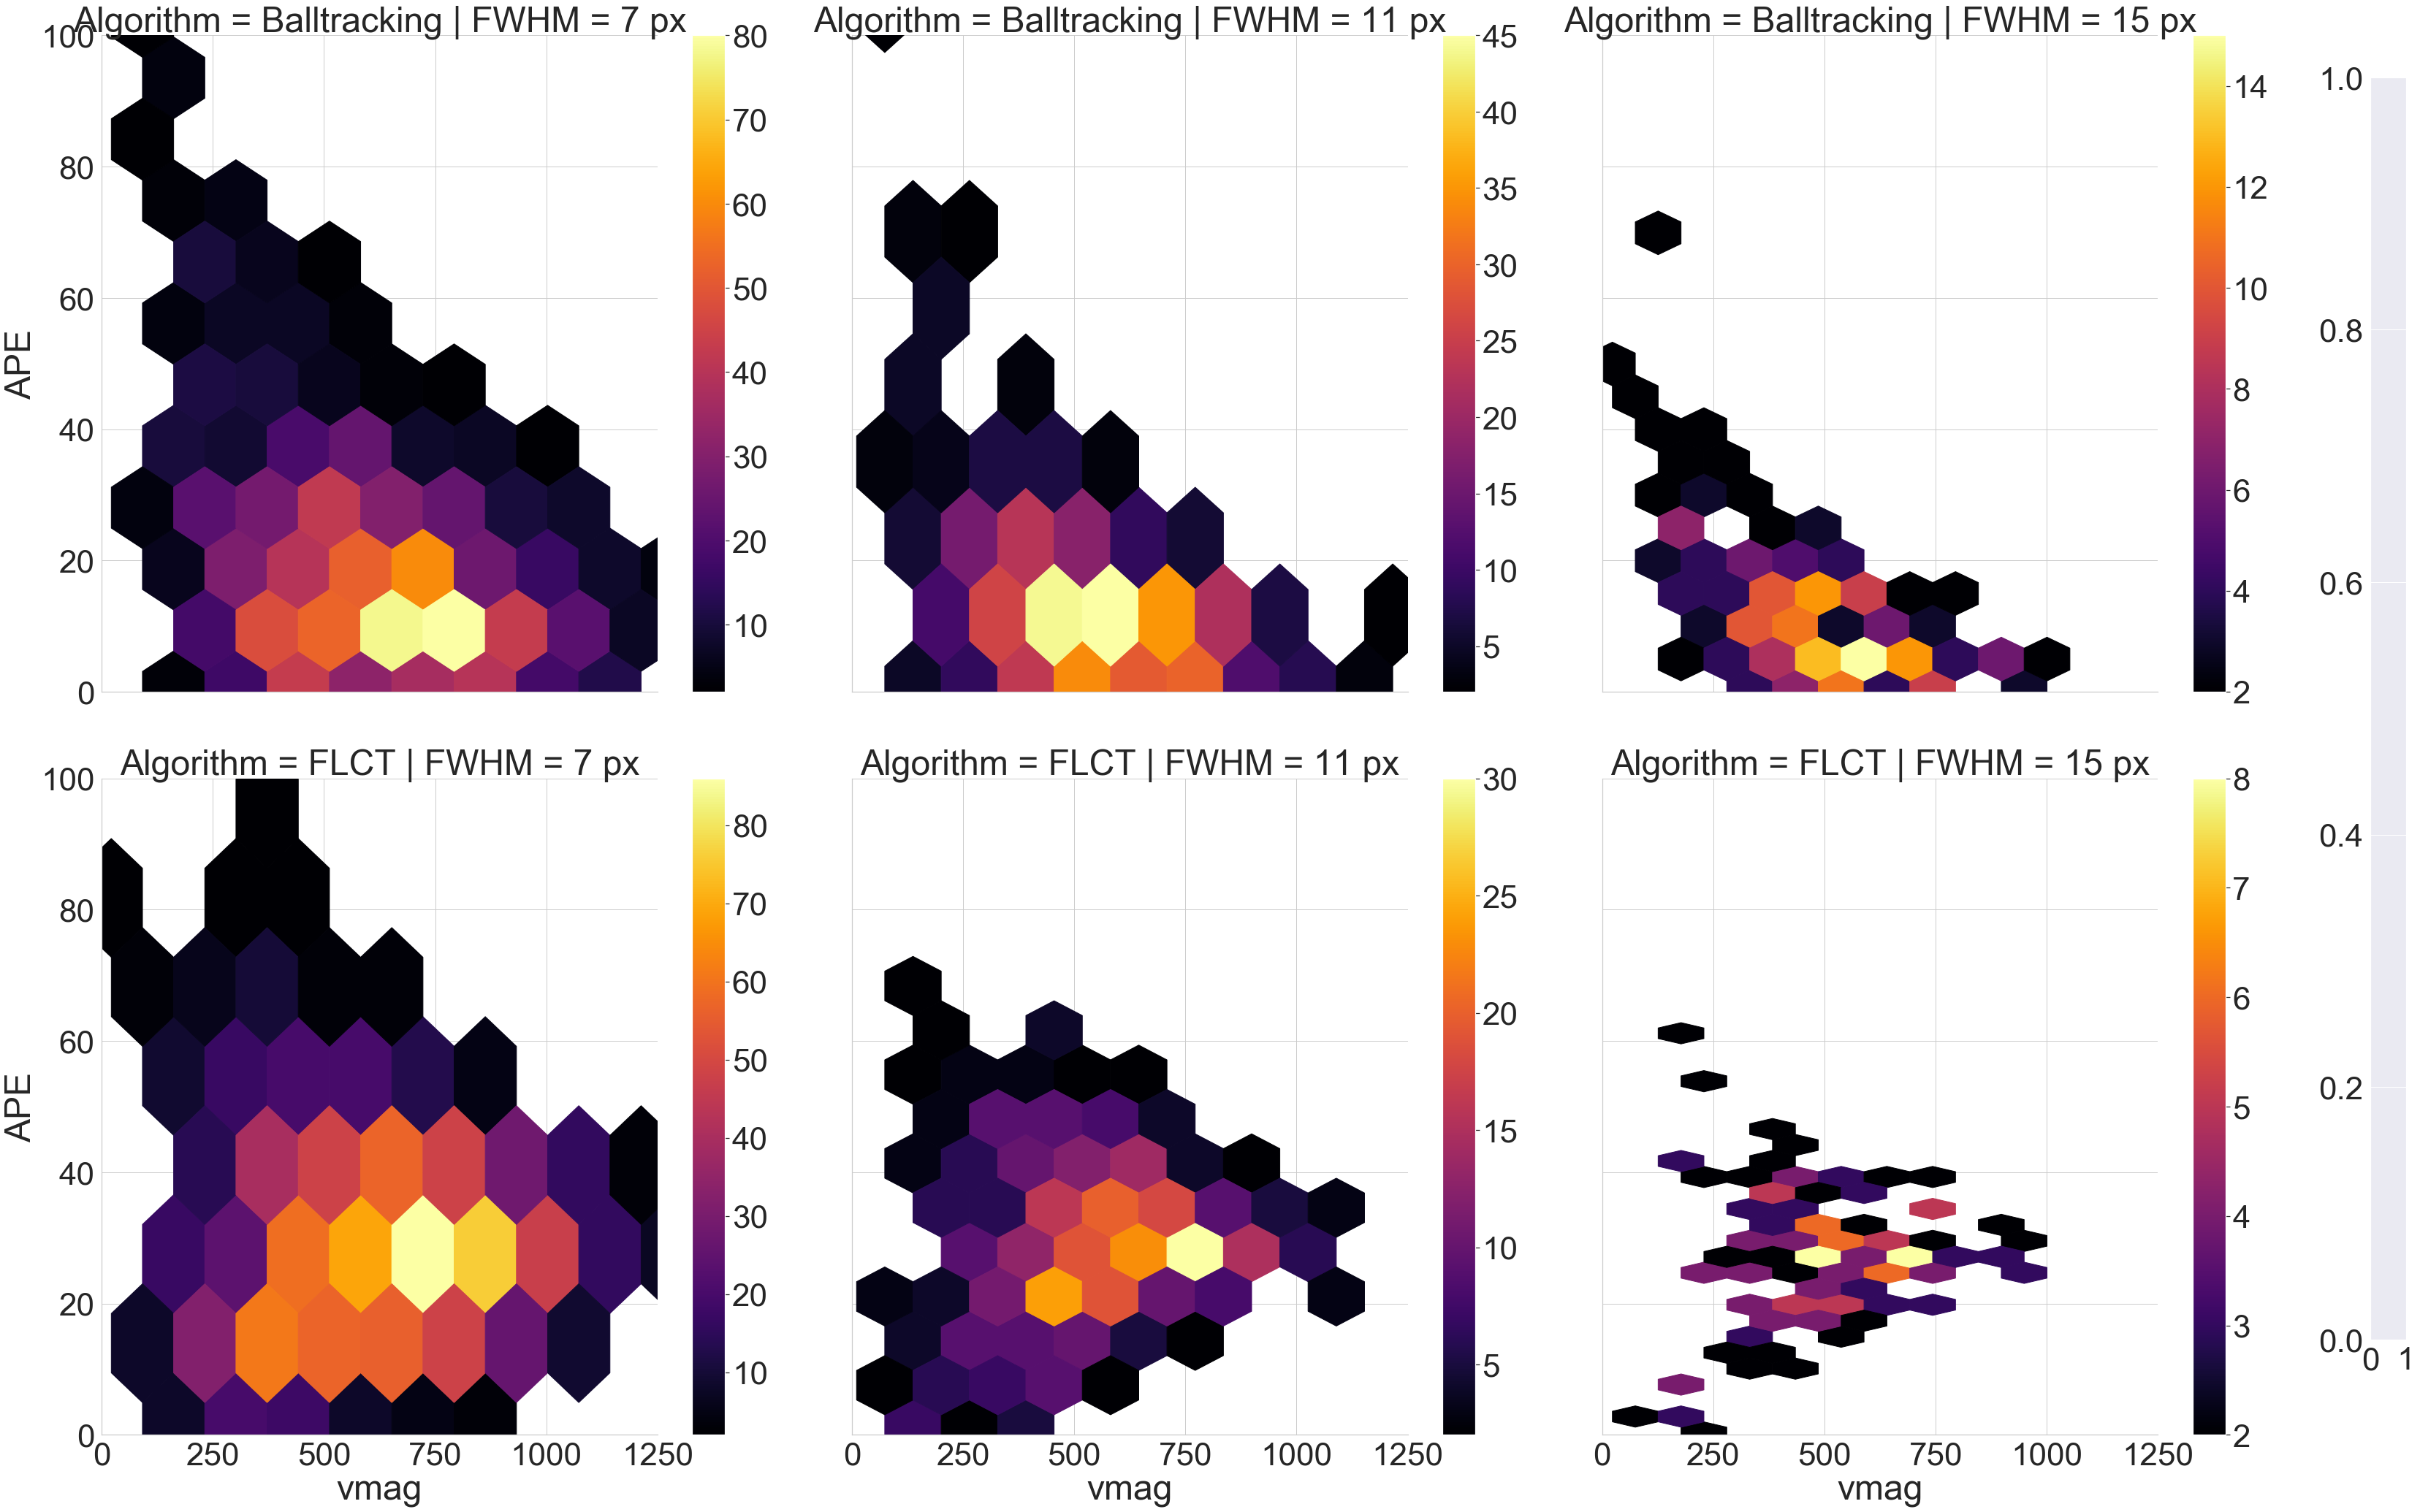

In [87]:
sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(df1.query("nframes == 190"), row='Algorithm', col='FWHM', height=15)
    
g.map(hexbin, 'vmag', 'APE');
g.set(xlim=[0, 1250], ylim=[0, 100]);
cbar_ax = g.fig.add_axes([1.015,0.13, 0.015, 0.8])

Text(23.340000000000003, 0.5, 'Probability density')

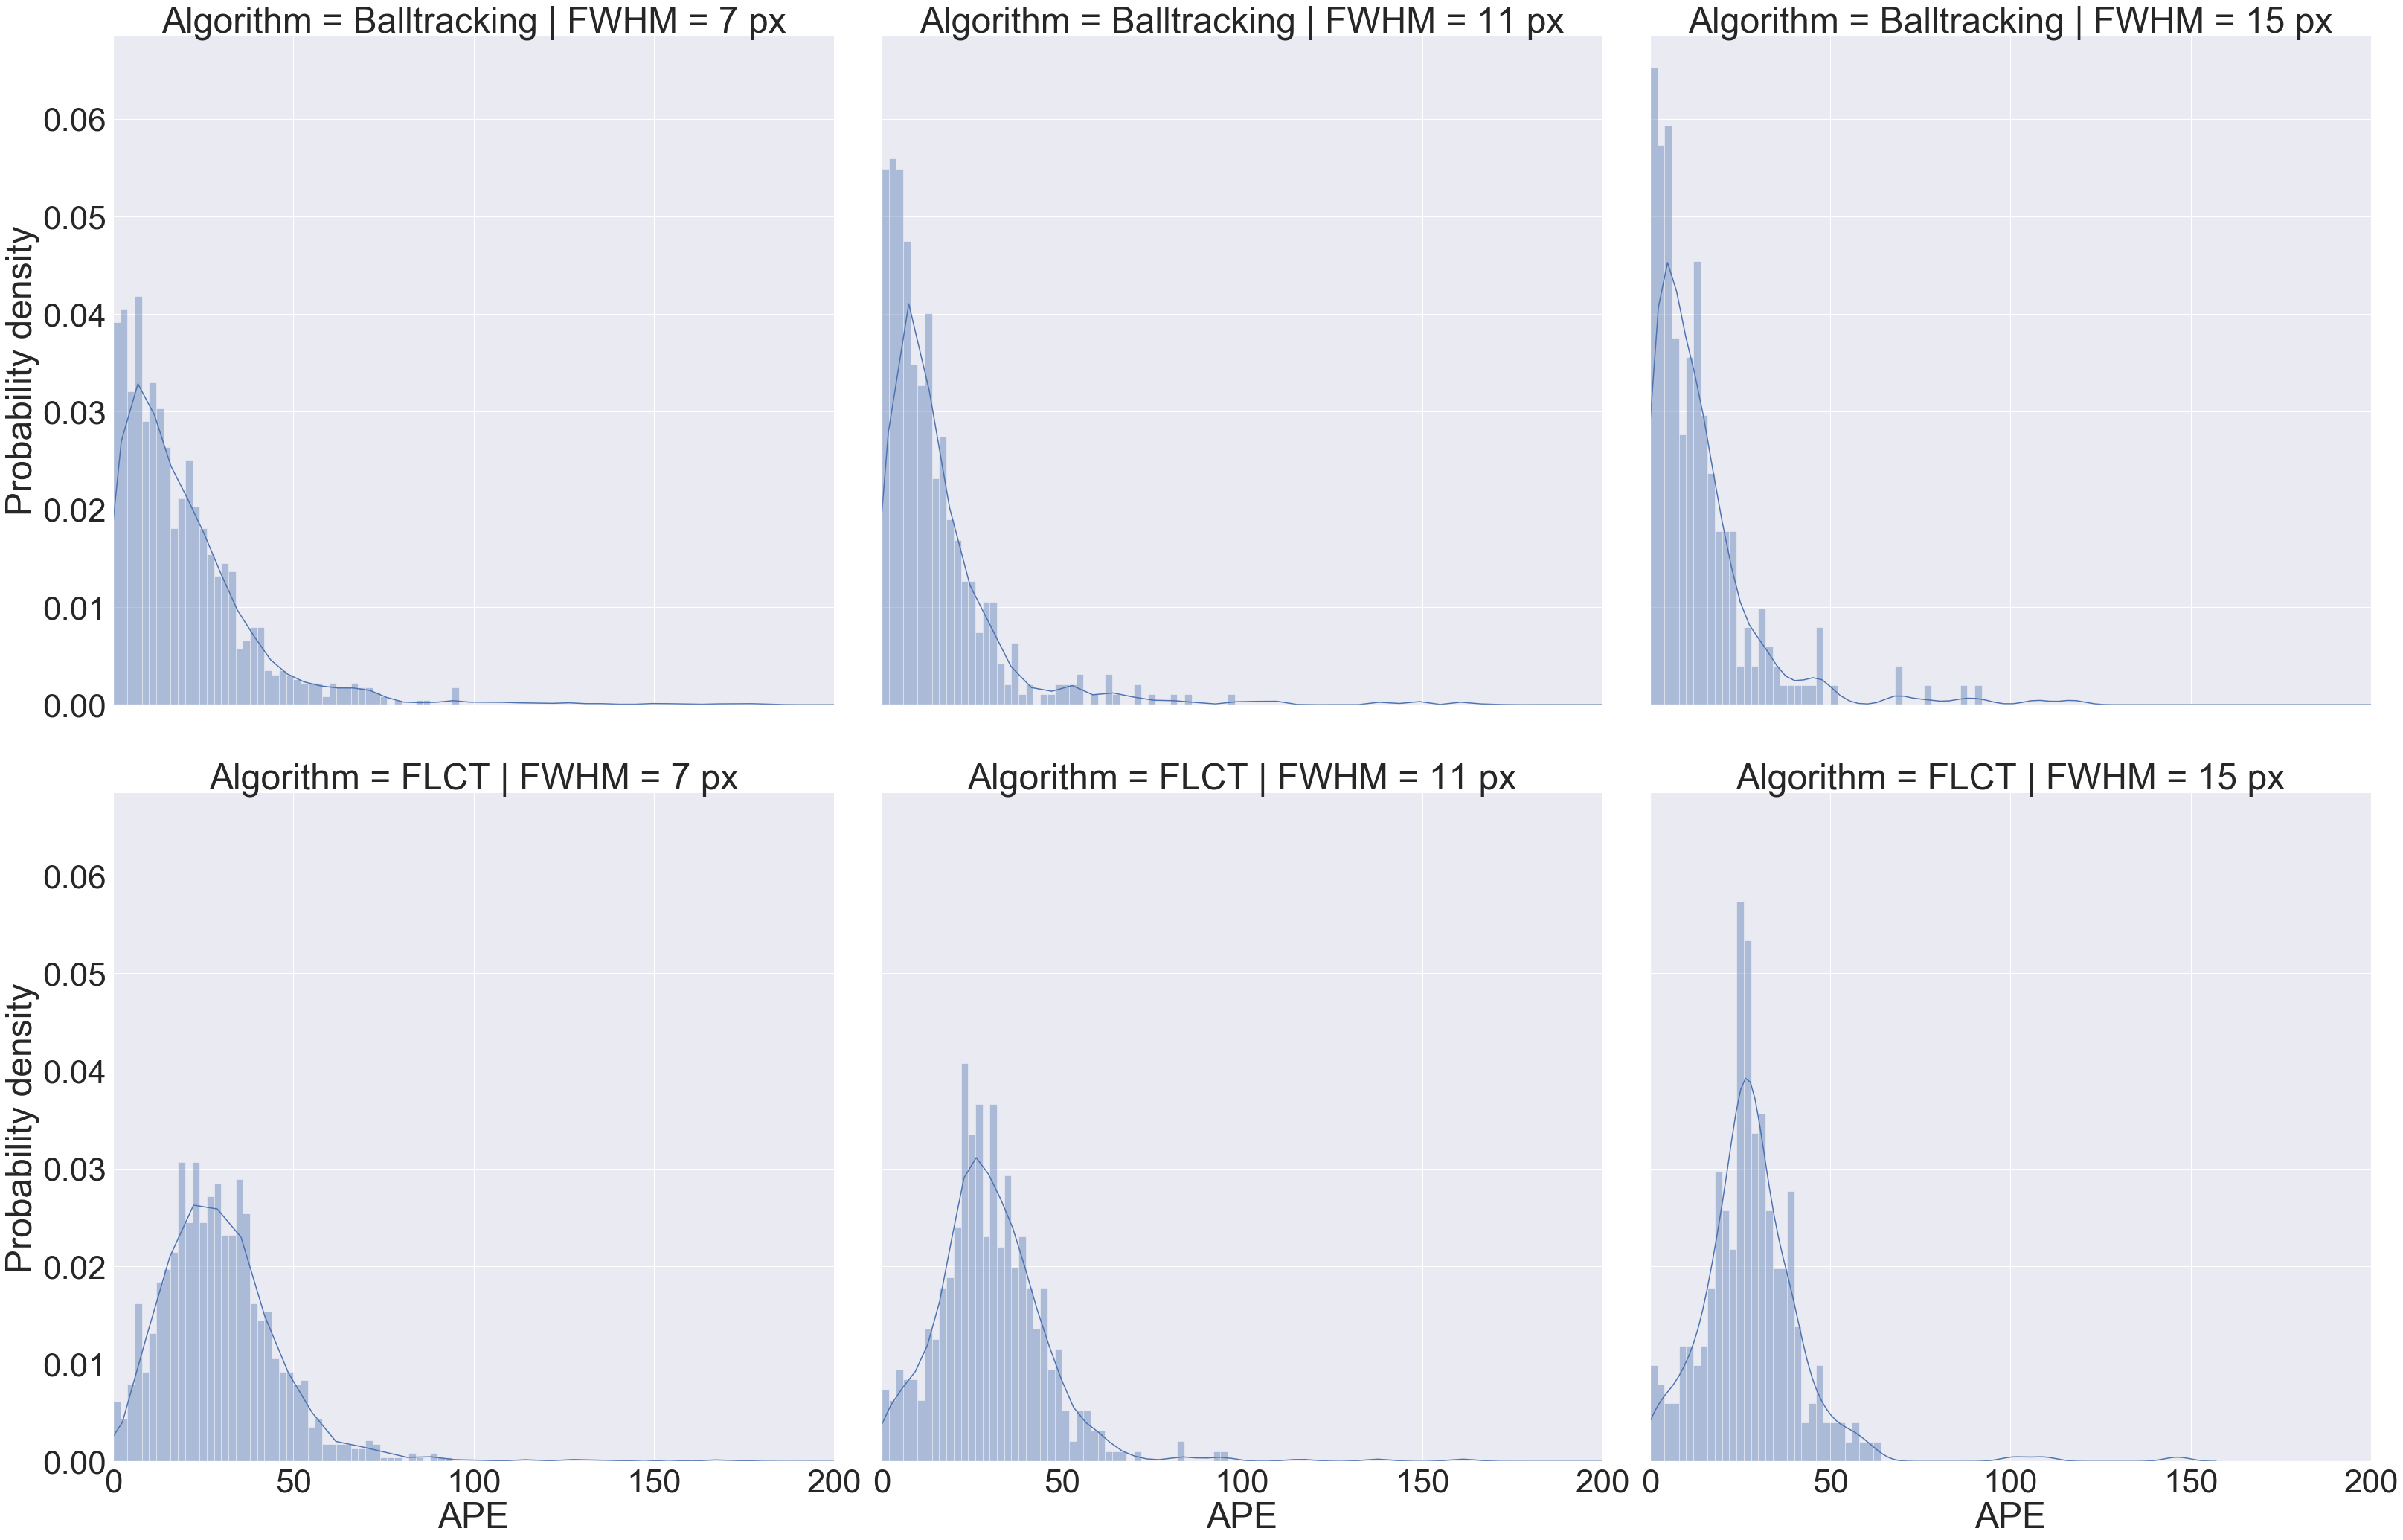

In [120]:
g = sns.FacetGrid(df1.query("nframes == 190"), row='Algorithm', col='FWHM', height=15)
g.map(sns.distplot, 'APE', bins=50, hist_kws={"range":[0, 100]})
g.set(xlim=[0, 200])
# g.set(xlabel='APE [%]', ylabel = 'density')

for ax in g.axes.flat:
    #ax.set_ticks(ax.get_title(), fontsize='xx-large')
    # This only works for the left ylabels
    #ax.set_xticks(range(0,101, 10))
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    
g.axes[0, 0].set_ylabel('Probability density')
g.axes[1, 0].set_ylabel('Probability density')

### Drift test